## Setup

In [ ]:
%%capture
# !pip install mne
!pip install pywavelets

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import mne

In [2]:
%%capture
PATH_TO_DATA = "data/"
categories = ('Healthy', 'Epileptic')

dataset = {categories[0]: [], categories[1]: []}

for category in categories:
  for file_name in glob.glob(f'{PATH_TO_DATA}/{category}/*.fif'):
    file_data = mne.io.read_raw_fif(file_name, preload=True)
    dataset[category].append(file_data)


# Process

In [3]:
raw = dataset['Healthy'][0]
raw1 = dataset['Epileptic'][0]

In [4]:
sigma = np.corrcoef(raw.get_data())
tetha = np.corrcoef(raw1.get_data())

In [5]:
sigma = np.corrcoef(raw.get_data()[:400])
tetha = np.corrcoef(raw1.get_data()[:400])

Trying the CWT method for 400 frames of the model to see we can get feature

In [6]:
import pywt
x = np.arange(400)
y = raw.get_data()[:400]

coef, freqs = pywt.cwt(y, np.arange(1, 400), 'gaus1')

# Visualize the CWT
plt.matshow(coef)
plt.show()

KeyboardInterrupt: 

Text(0.5, 1.0, 'Covariavnce Matrix for epileptic patient')

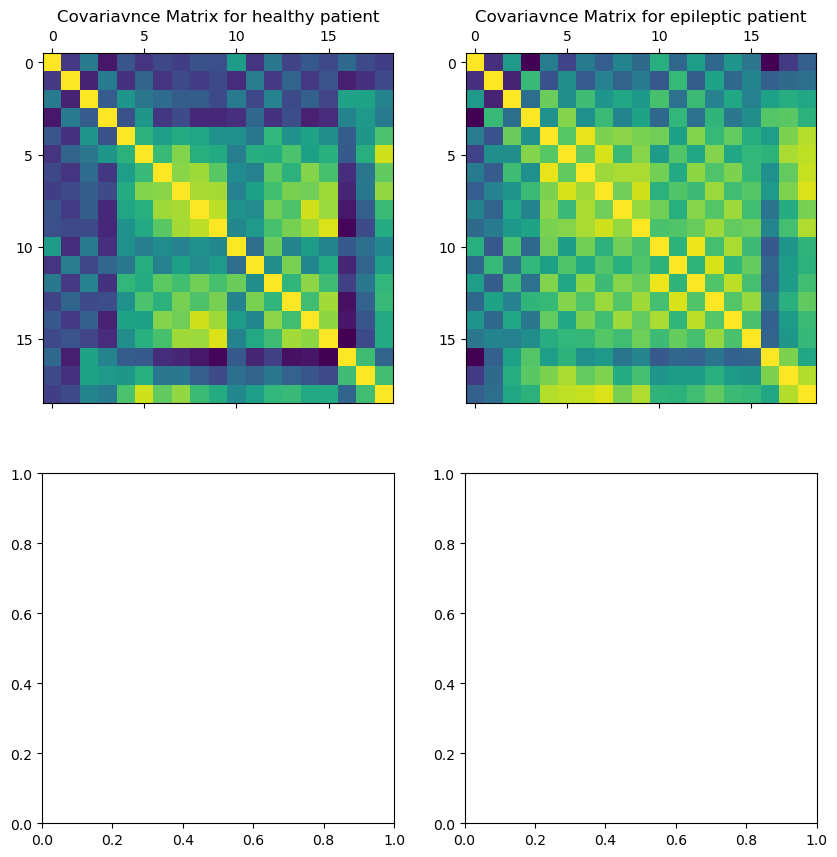

In [7]:
fig , ax = plt.subplots(ncols=2, nrows=2,figsize=(10,10))
ax[0,0].matshow(sigma)
ax[0,0].set_title('Covariavnce Matrix for healthy patient')
ax[0,1].matshow(tetha)
ax[0,1].set_title('Covariavnce Matrix for epileptic patient')

In [8]:
raw = dataset['Healthy'][13]
raw.plot(duration=5)
True

Using qt as 2D backend.


True

Channels marked as bad:
none


Effective window size : 16.384 (s)


C:\Users\abhis\AppData\Local\Temp\ipykernel_17588\4116875027.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  psd.plot(picks="data", exclude="bads")
C:\Users\abhis\miniconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


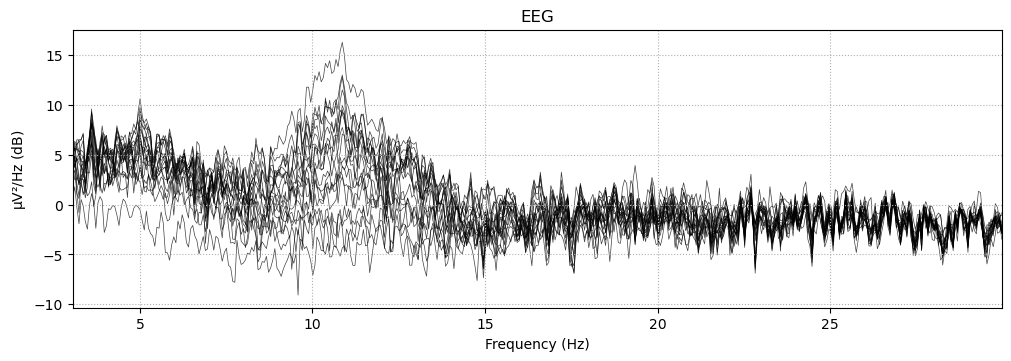

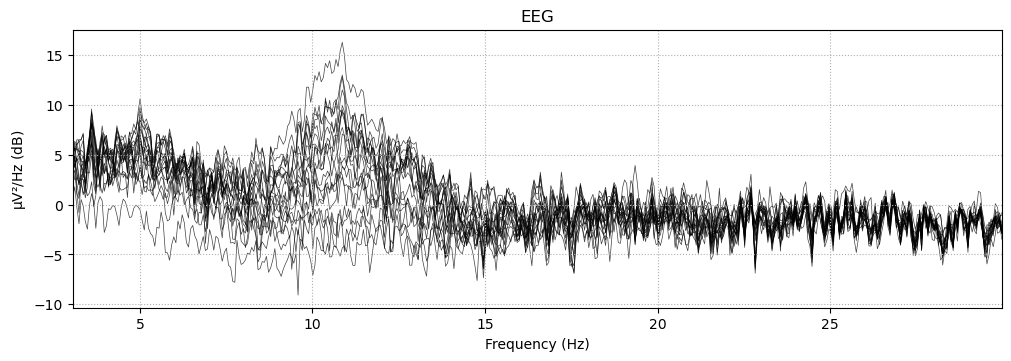

In [9]:
psd = raw.compute_psd(fmax=30, fmin=3)
psd.plot(picks="data", exclude="bads")

Effective window size : 16.384 (s)


C:\Users\abhis\AppData\Local\Temp\ipykernel_17588\680188344.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  psd.plot(picks="data", exclude="bads")
C:\Users\abhis\miniconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


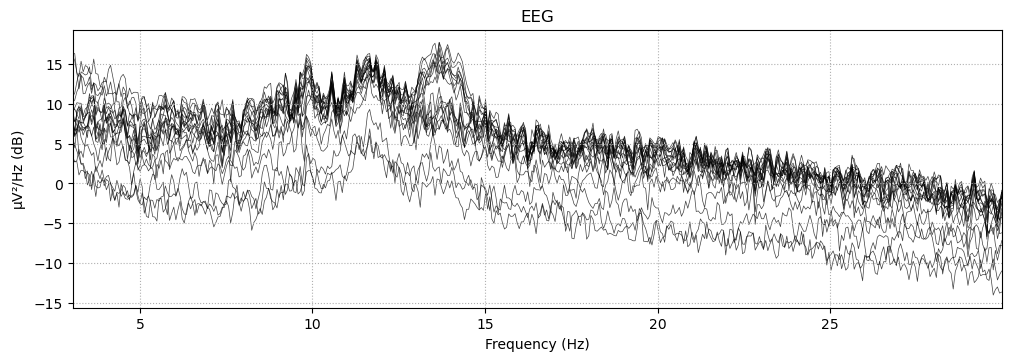

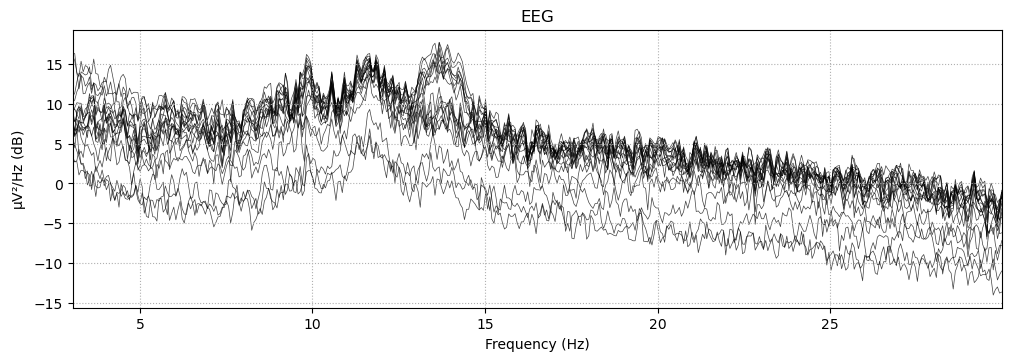

In [10]:
psd = raw1.compute_psd(fmax=30, fmin=3)
psd.plot(picks="data", exclude="bads")

In [11]:
len(raw)

29376

## Process 2

In [12]:
STEP_SIZE = 200
cov_dataset = {categories[0]: [], categories[1]: []}
dlen = 0

skip_len = 0
for category in categories:
  for patient_data in dataset[category]:
    patient_arr = patient_data.get_data()
    for i in range(0, len(patient_data), STEP_SIZE):
      cov_mat = np.corrcoef(patient_arr[:, i:i+STEP_SIZE])

      try:
        eig_vals = sorted(np.linalg.eigvals(cov_mat))
        cov_dataset[category].append(eig_vals[-1] / eig_vals[-2]) #dividing the eigen values
        dlen += 1
      except:
        skip_len += 1

C:\Users\abhis\miniconda3\envs\mne\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\abhis\miniconda3\envs\mne\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\abhis\miniconda3\envs\mne\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [13]:
healthy = np.array(cov_dataset['Healthy'])
epileptic = np.array(cov_dataset['Epileptic'])

In [65]:
NUM_BINS = 50
def calc_bin_index(s, mean, sigma, dont_skip=True):
    index = int(((s - mean)  / (4*sigma)   + 0.5) * NUM_BINS)
    if dont_skip:
        if index < 0: index = 0
        if index > NUM_BINS - 1: index = NUM_BINS - 1
    return index

def make_histogram(s, mean, sigma):
    a = np.zeros(NUM_BINS, dtype=np.int32)
    skipped = 0
    for value in s:
        index = calc_bin_index(value, mean, sigma, dont_skip=False)
        if index >= 0 and index < NUM_BINS - 1: a[index] += 1
        else: skipped += 1
    print(skipped)
    return a/sum(a)

In [15]:
hist_healthy = make_histogram(healthy , np.mean(healthy) , np.std(healthy))
hist_epileptic = make_histogram(epileptic , np.mean(epileptic) , np.std(epileptic))

151
168


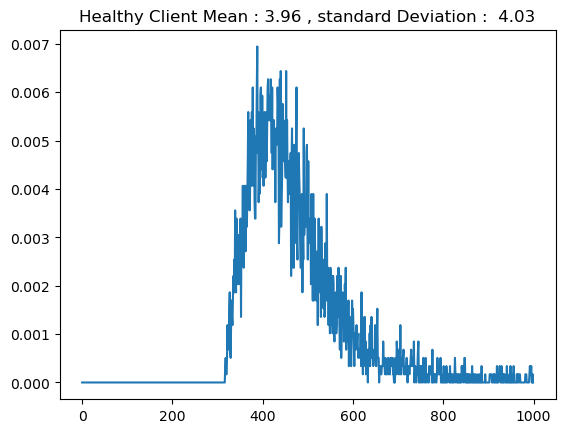

Text(0.5, 1.0, 'Epileptic Client Mean : 3.49 , standard Deviation :  2.36')

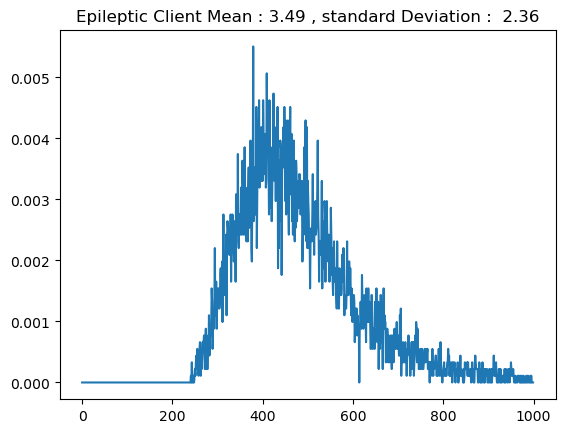

In [17]:
import matplotlib.pyplot as plt
plt.plot(hist_healthy)
plt.title('Healthy Client Mean : {:.2f} , standard Deviation :  {:.2f}'.format(np.mean(healthy) , np.std(healthy)))
plt.show()
plt.plot(hist_epileptic)
plt.title('Epileptic Client Mean : {:.2f} , standard Deviation :  {:.2f}'.format(np.mean(epileptic) , np.std(epileptic)))

In [18]:
def calc_lr(hist_healthy , hist_epileptic , x):
    p1 = hist_healthy[calc_bin_index(x,  0, 1)]
    p2 = hist_epileptic[calc_bin_index(x,  4, 1)]
    return p2/p1

def classify( hist_healthy , hist_epileptic , x, tau = 1):
    if calc_lr(hist_healthy , hist_epileptic ,  x) > tau: return True
    else: return False

In [ ]:
test_ds = np.append(healthy[:5000], epileptic[:5000])
test_ds.shape
fp_arr, tp_arr = [], []
import ipdb
for tau in np.arange(3, 4, 0.1):
    results = np.empty(test_ds.shape)
    for i,samp in enumerate(test_ds):
        ipdb.set_trace()
        results[i] = classify(hist_healthy , hist_epileptic , samp, tau=tau)

    num_fp = sum(results[:5000])
    num_tp = sum(results[5000:])
    fp_arr.append(num_fp)
    tp_arr.append(num_tp)
# print(fp_arr , tp)
plt.plot(fp_arr , tp_arr)


In [ ]:
print( np.mean(healthy) , np.std(healthy) , np.mean(epileptic) , np.std(epileptic) )


3.961291431911192 4.028013947709306 3.4940739292491196 2.3592794941399324


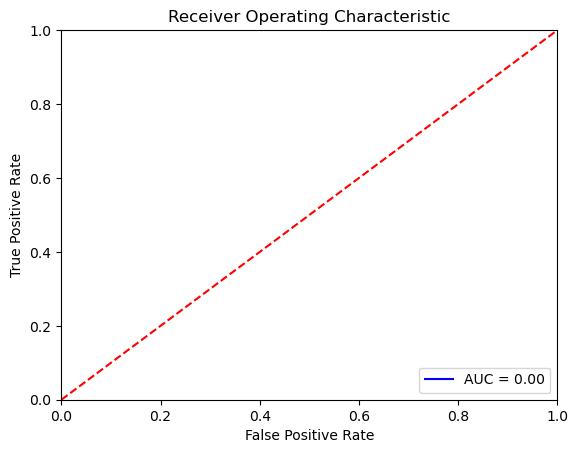

In [29]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
roc_auc = metrics.auc(fp_arr, tp_arr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fp_arr, tp_arr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


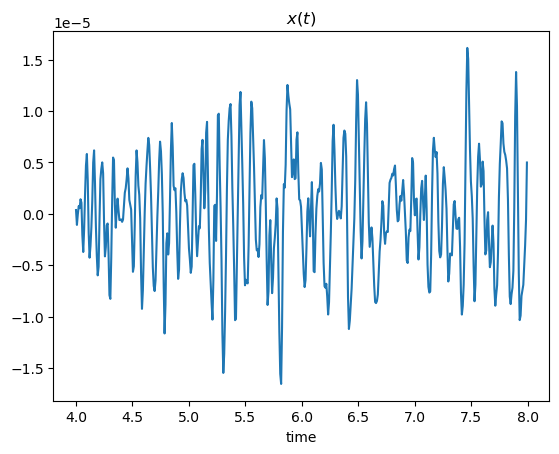

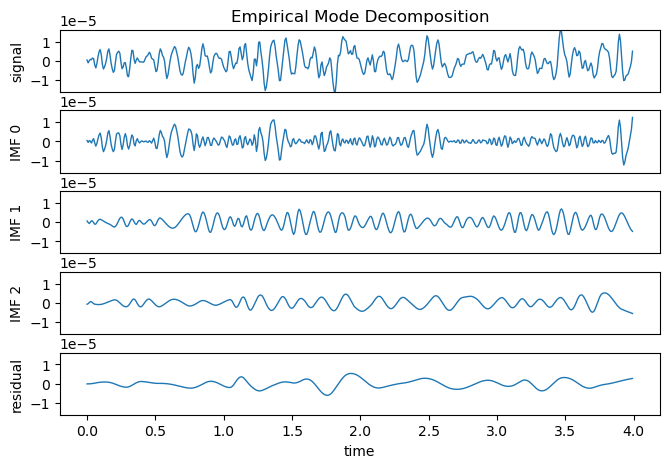

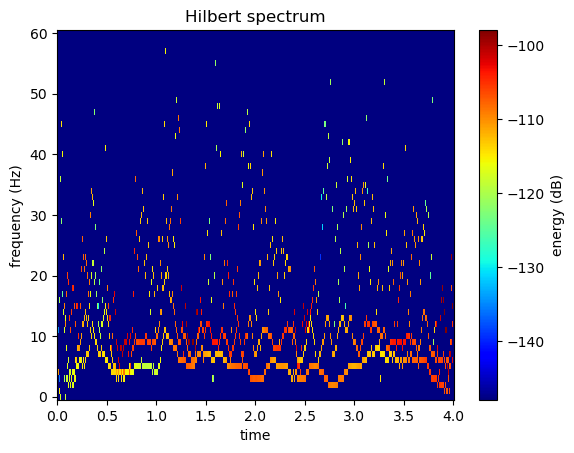

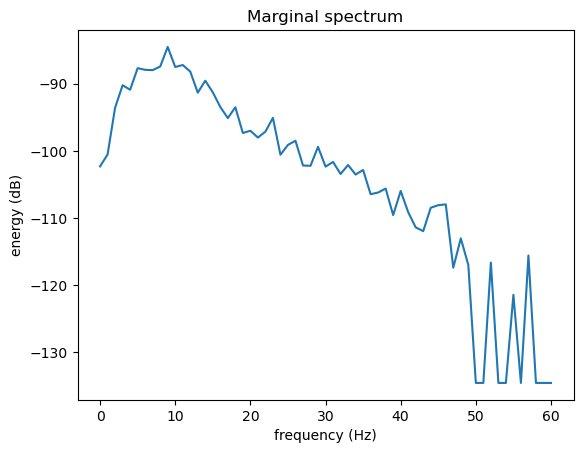

In [9]:

# import torch
# import numpy as np
# from matplotlib import pyplot as plt
# from torchHHT import hht, visualization
# from scipy.signal import chirp
# import IPython
# from scipy.stats import norm
# import glob 
# import mne 

# PATH_TO_DATA = "data/"
# categories = ('Healthy', 'Epileptic')

# dataset = {categories[0]: [], categories[1]: []}

# for category in categories:
#   for file_name in glob.glob(f'{PATH_TO_DATA}/{category}/*.fif'):
#     file_data = mne.io.read_raw_fif(file_name, preload=True)
#     dataset[category].append(file_data)

# raw = dataset['Healthy'][0]
# raw1 = dataset['Epileptic'][0]

fs = 125
duration = 2.0
t = raw1.times[500:1000]
type = 'Epileptic_full_channel_0'
x = torch.from_numpy(raw1.get_data()[0][500:1000])
x.to('cuda')
plt.plot(t, x) 
plt.title("$x(t)$")
plt.xlabel("time")
plt.show()

imfs, imfs_env, imfs_freq = hht.hilbert_huang(x, fs, num_imf=3)
visualization.plot_IMFs(x, imfs, fs, save_fig=f"img/{type}.png")
spectrum, t, f = hht.hilbert_spectrum(imfs_env, imfs_freq, fs, freq_lim = (0, 60), time_scale=1, freq_res = 1)
visualization.plot_HilbertSpectrum(spectrum, t, f, 
                                    save_spectrum=f"img/Hilbert_spectrum_{type}.png", 
                                    save_marginal=f"img/Hilbert_marginal_{type}.png")

In [89]:
### For Epileptic Patient Data #########
## raw = non
## raw1 = epileptic 
channel = 10
start = 0 
end = raw1.get_data()[channel].shape[0]
fs = 125
duration = 2.0
t = raw1.times[start:end]
type_eg = 'Epileptic_full_channel_0'
x1 = torch.from_numpy(raw1.get_data()[0][start:end])
x1.to('cuda')
imf_ep, imfs_env, imfs_freq = hht.hilbert_huang(x1, fs, num_imf=3)
t = raw.times[start:end]
type_eg = 'Epileptic_full_channel_0'
x = torch.from_numpy(raw.get_data()[channel][start:end])
x.to('cuda')

imf_non, imfs_env, imfs_freq = hht.hilbert_huang(x, fs, num_imf=3)
spectrum, t, f = hht.hilbert_spectrum(imfs_env, imfs_freq, fs, freq_lim = (3, 30), time_scale=1, freq_res = 1)
print(spectrum.shape , t.shape , f.shape)
# visualization.plot_HilbertSpectrum(spectrum, t, f, 
#                                     save_spectrum=f"img/Hilbert_spectrum_{type}.png", 
#                                     save_marginal=f"img/Hilbert_marginal_{type}.png")

################## ------------------ Hilbert IMF ----------------####################

# for i in range(1 , imfs.shape[0]+1):
#     res = x - imf_non[i-1]
#     res1 = x1 - imf_ep[i-1]
#     plt.subplot(4,1,i)
#     plt.plot(make_histogram(imf_non[i-1] , torch.mean(imf_non[i-1]) , torch.std(imf_non[i-1] )))
#     plt.plot(make_histogram(imf_ep[i-1] , torch.mean(imf_ep[i-1]) , torch.std(imf_ep[i-1] )))
#     plt.plot(imf_non[i-1])
#     plt.plot(imf_ep[i-1] )
#     print(f'{i}_non mean : {torch.mean(imf_non[i-1])} std : {torch.std(imf_non[i-1] )} vs \
#     mean : {torch.mean(imf_ep[i-1])} std : {torch.std(imf_ep[i-1] )}     {i}_epi ')
# plt.subplot(4,1,4)
# plt.plot(make_histogram(res , torch.mean(res) , torch.std(res) ))
# plt.plot(make_histogram(res1 , torch.mean(res1) , torch.std(res1) ))
# plt.plot(res)
# plt.plot(res1)


torch.Size([38752, 28]) torch.Size([38752]) torch.Size([28])


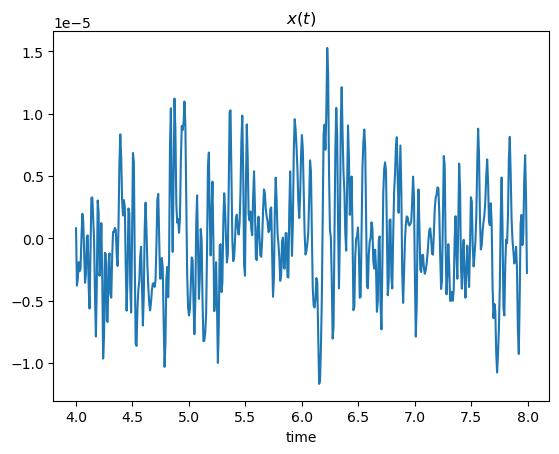

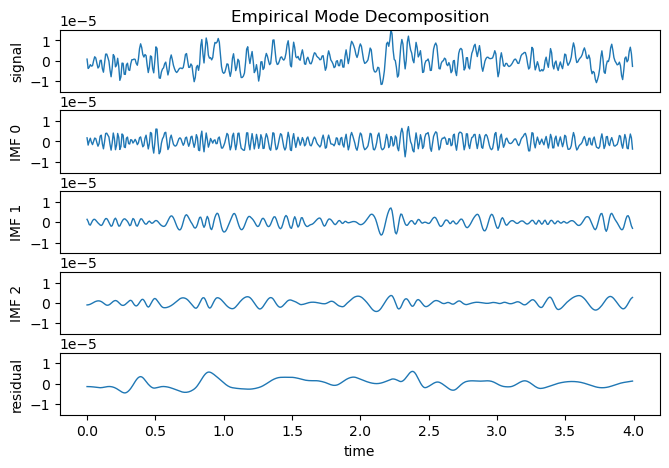

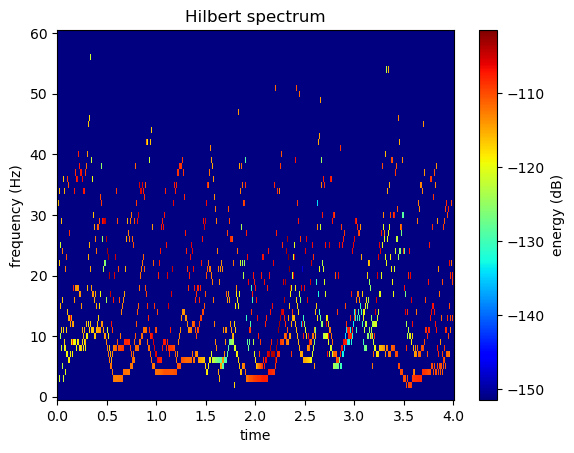

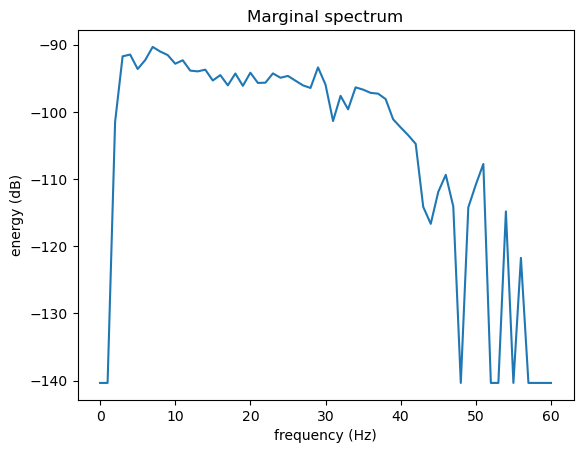

In [10]:
fs = 125
duration = 2.0
t = raw.times[500:1000]
type = 'Epileptic_full_channel_0'
x = torch.from_numpy(raw.get_data()[0][500:1000])
x.to('cuda')
plt.plot(t, x) 
plt.title("$x(t)$")
plt.xlabel("time")
plt.show()

imfs, imfs_env, imfs_freq = hht.hilbert_huang(x, fs, num_imf=3)
visualization.plot_IMFs(x, imfs, fs, save_fig=f"img/{type}.pnimfs, imfs_env, imfs_freqg")
spectrum, t, f = hht.hilbert_spectrum(imfs_env, imfs_freq, fs, freq_lim = (0, 60), time_scale=1, freq_res = 1)
visualization.plot_HilbertSpectrum(spectrum, t, f, 
                                    save_spectrum=f"img/Hilbert_spectrum_{type}.png", 
                                    save_marginal=f"img/Hilbert_marginal_{type}.png")

(array([ 4.,  1.,  1.,  4.,  5., 11., 16., 16., 16., 26., 14., 26., 34.,
        26., 39., 33., 31., 33., 27., 31., 25., 13., 18., 15.,  9.,  9.,
         3.,  6.,  5.,  3.]),
 array([-5.97243026e-06, -5.58151177e-06, -5.19059329e-06, -4.79967480e-06,
        -4.40875632e-06, -4.01783783e-06, -3.62691935e-06, -3.23600086e-06,
        -2.84508238e-06, -2.45416389e-06, -2.06324540e-06, -1.67232692e-06,
        -1.28140843e-06, -8.90489949e-07, -4.99571464e-07, -1.08652978e-07,
         2.82265507e-07,  6.73183992e-07,  1.06410248e-06,  1.45502096e-06,
         1.84593945e-06,  2.23685793e-06,  2.62777642e-06,  3.01869490e-06,
         3.40961339e-06,  3.80053187e-06,  4.19145036e-06,  4.58236884e-06,
         4.97328733e-06,  5.36420582e-06,  5.75512430e-06]),
 <BarContainer object of 30 artists>)

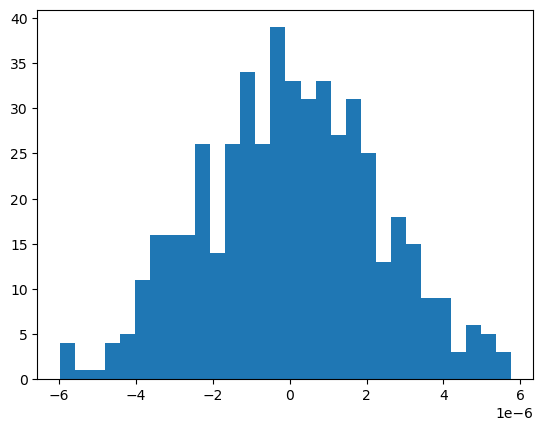

In [64]:
plt.hist(imf_ep[0] , 30)